# New York is Burning
Project Description

## Intro
Import initial libraries.

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from datetime import datetime

Read the data set

In [42]:
df = pd.read_csv("weather_data.csv")[["DATE", "TMAX", "TMIN",]]
df = df.copy()

Fill na, and group monthly and yearly.

In [43]:
df["DATE"] = df["DATE"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df.index = df["DATE"]
df.drop(columns="DATE", inplace=True)
df["TMAX"].fillna(method="ffill", inplace=True)
df["TMIN"].fillna(method="ffill", inplace=True)
monthly_df = df.groupby(pd.Grouper(freq="M")).mean()
yearly_df = df.groupby(pd.Grouper(freq="Y")).mean()

## Decomposing Seasonally
define lag and diff. plot the results

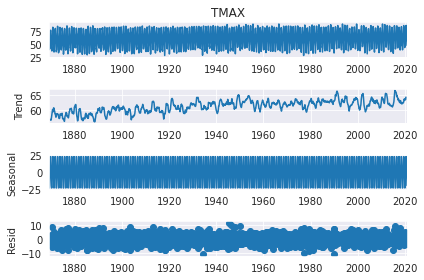

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(monthly_df["TMAX"], model="additive")
result.plot()
plt.show()

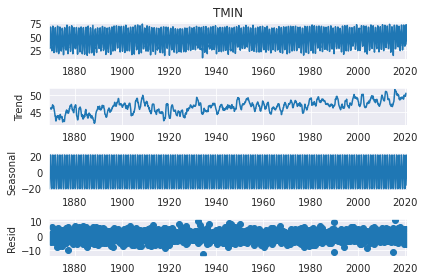

In [45]:
result = seasonal_decompose(monthly_df["TMIN"], model="additive")
result.plot()
plt.show()

### Create Lag and Diff

In [46]:
monthly_df["tmax_lag1"] = monthly_df["TMAX"].shift(1)
monthly_df["tmax_diff1"] = monthly_df["TMAX"].diff(periods=1)
monthly_df["tmin_lag1"] = monthly_df["TMIN"].shift(1)
monthly_df["tmin_diff1"] = monthly_df["TMIN"].diff(periods=1)

monthly_df.dropna(inplace=True)

### Train Test Split

In [47]:
train_size = int(monthly_df.shape[0] * 0.9)
train = monthly_df[:train_size]
test = monthly_df[train_size:]

X_train, y_train = train[["tmax_lag1", "tmin_lag1"]], train[["TMAX", "TMIN"]]
X_test, y_test = test[["tmax_lag1", "tmin_lag1"]], test[["TMAX", "TMIN"]]

calculate base prediction mean absolute error.

## Monthly Analysis

### Base Model

In [48]:
predictions = X_test.copy()

In [49]:
from sklearn.metrics import mean_absolute_error
tmax_mae = mean_absolute_error(y_test["TMAX"], predictions["tmax_lag1"])
tmin_mae = mean_absolute_error(y_test["TMIN"], predictions["tmin_lag1"])
print(tmax_mae)
print(tmin_mae)

8.06212888116643
7.557477284877491


plot the base prediction.

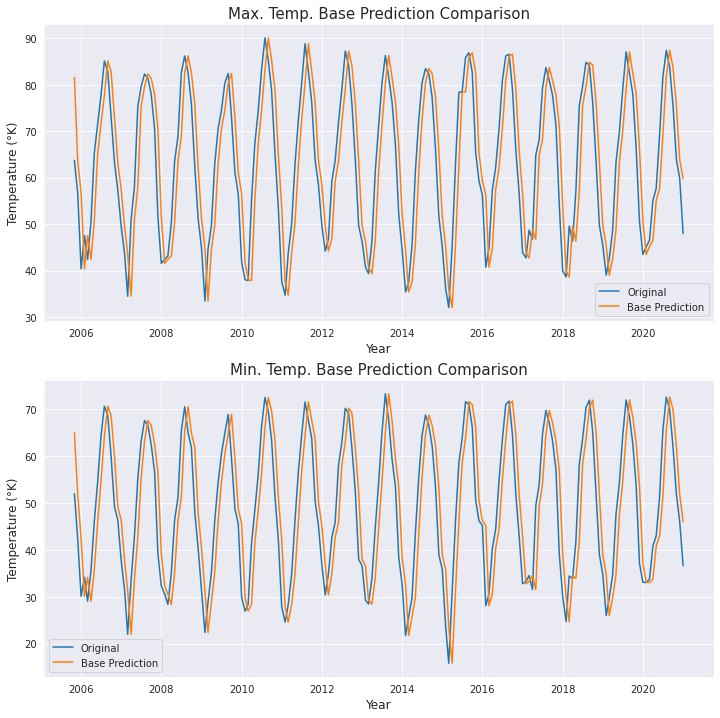

In [50]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 12))
sns.lineplot(x=y_test.index, y=y_test["TMAX"].values, label="Original", ax=axes[0])
sns.lineplot(x=predictions.index, y=predictions["tmax_lag1"].values,
             label="Base Prediction", ax=axes[0])
axes[0].set_title("Max. Temp. Base Prediction Comparison", fontsize=15)
axes[0].set_ylabel("Temperature (°K)", fontsize=12)
axes[0].set_xlabel("Year", fontsize=12)
sns.lineplot(x=y_test.index, y=y_test["TMIN"].values, label="Original", ax=axes[1])
sns.lineplot(x=predictions.index, y=predictions["tmin_lag1"].values,
			 label="Base Prediction", ax=axes[1])
axes[1].set_title("Min. Temp. Base Prediction Comparison", fontsize=15)
axes[1].set_ylabel("Temperature (°K)", fontsize=12)
axes[1].set_xlabel("Year", fontsize=12)
plt.show()

### Auto Regression Model

Define the model

In [51]:
from statsmodels.tsa.ar_model import AutoReg

tmax_model = AutoReg(train["TMAX"], lags=50)
tmin_model = AutoReg(train["TMIN"], lags=50)
tmax_model_fit = tmax_model.fit()
tmin_model_fit = tmin_model.fit()

we have the following parameters values.

In [52]:
print(tmax_model_fit.params)
print(tmin_model_fit.params)

const       7.798599
TMAX.L1     0.254080
TMAX.L2     0.044075
TMAX.L3     0.003002
TMAX.L4     0.047581
TMAX.L5    -0.051167
TMAX.L6     0.033627
TMAX.L7     0.030467
TMAX.L8    -0.024330
TMAX.L9    -0.001184
TMAX.L10    0.015063
TMAX.L11    0.045191
TMAX.L12    0.087697
TMAX.L13    0.019732
TMAX.L14   -0.011099
TMAX.L15   -0.017787
TMAX.L16   -0.028293
TMAX.L17   -0.031658
TMAX.L18   -0.021106
TMAX.L19    0.017364
TMAX.L20   -0.012457
TMAX.L21   -0.019109
TMAX.L22    0.045800
TMAX.L23    0.022998
TMAX.L24    0.056863
TMAX.L25    0.059537
TMAX.L26    0.053449
TMAX.L27   -0.014704
TMAX.L28    0.037795
TMAX.L29   -0.019174
TMAX.L30    0.000987
TMAX.L31   -0.013128
TMAX.L32    0.001475
TMAX.L33   -0.009555
TMAX.L34    0.037162
TMAX.L35    0.022666
TMAX.L36    0.059464
TMAX.L37    0.041406
TMAX.L38   -0.015811
TMAX.L39   -0.030736
TMAX.L40    0.005094
TMAX.L41   -0.073566
TMAX.L42    0.003213
TMAX.L43   -0.031845
TMAX.L44   -0.026952
TMAX.L45    0.081456
TMAX.L46    0.017536
TMAX.L47    0

we have the following mean absolute error:

In [53]:
tmax_predictions = tmax_model_fit.predict(start=len(train), end=len(train) + len(test) - 1)
tmin_predictions = tmin_model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

tmax_mae = mean_absolute_error(y_test["TMAX"], tmax_predictions)
tmin_mae = mean_absolute_error(y_test["TMIN"], tmin_predictions)
print(tmax_mae)
print(tmin_mae)

2.7522724172232884
2.7850020811857665


the prediction looks like:

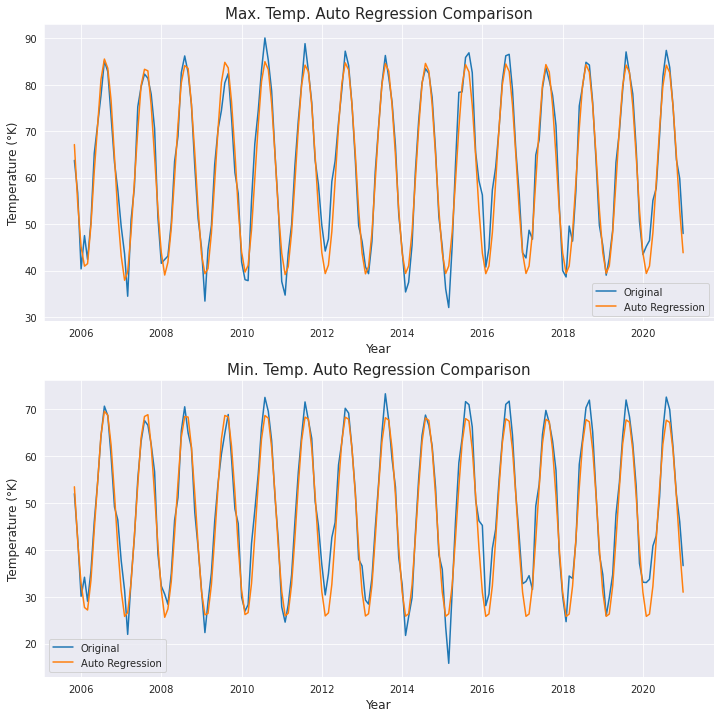

In [54]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 12))
sns.lineplot(x=y_test.index, y=y_test["TMAX"].values, label="Original", ax=axes[0])
sns.lineplot(x=tmax_predictions.index, y=tmax_predictions.values,
			 label="Auto Regression", ax=axes[0])
axes[0].set_title("Max. Temp. Auto Regression Comparison", fontsize=15)
axes[0].set_ylabel("Temperature (°K)", fontsize=12)
axes[0].set_xlabel("Year", fontsize=12)
sns.lineplot(x=y_test.index, y=y_test["TMIN"].values, label="Original", ax=axes[1])
sns.lineplot(x=tmin_predictions.index, y=tmin_predictions.values,
			 label="Auto Regression", ax=axes[1])
axes[1].set_title("Min. Temp. Auto Regression Comparison", fontsize=15)
axes[1].set_ylabel("Temperature (°K)", fontsize=12)
axes[1].set_xlabel("Year", fontsize=12)
plt.show()

### Auto Regression with Walk Forward

define the model.

In [55]:
data = train["TMAX"].copy()
tmax_predictions = []
for t in test["TMAX"]:
	model = AutoReg(data, lags=50)
	model_fit = model.fit()
	y = model_fit.predict(start=len(data), end=len(train) + len(test) - 1)
	tmax_predictions.append(y.values[0])
	data = np.append(data, t)
	data = pd.Series(data)

data = train["TMIN"].copy()
tmin_predictions = []
for t in test["TMIN"]:
	model = AutoReg(data, lags=50)
	model_fit = model.fit()
	y = model_fit.predict(start=len(data), end=len(train) + len(test) - 1)
	tmin_predictions.append(y.values[0])
	data = np.append(data, t)
	data = pd.Series(data)

we have the following mean absolute error:

In [56]:
tmax_mae = mean_absolute_error(y_test["TMAX"], tmax_predictions)
tmin_mae = mean_absolute_error(y_test["TMIN"], tmin_predictions)
print(tmax_mae)
print(tmin_mae)

2.7988267480661593
2.4661627016666725


and the following graph:

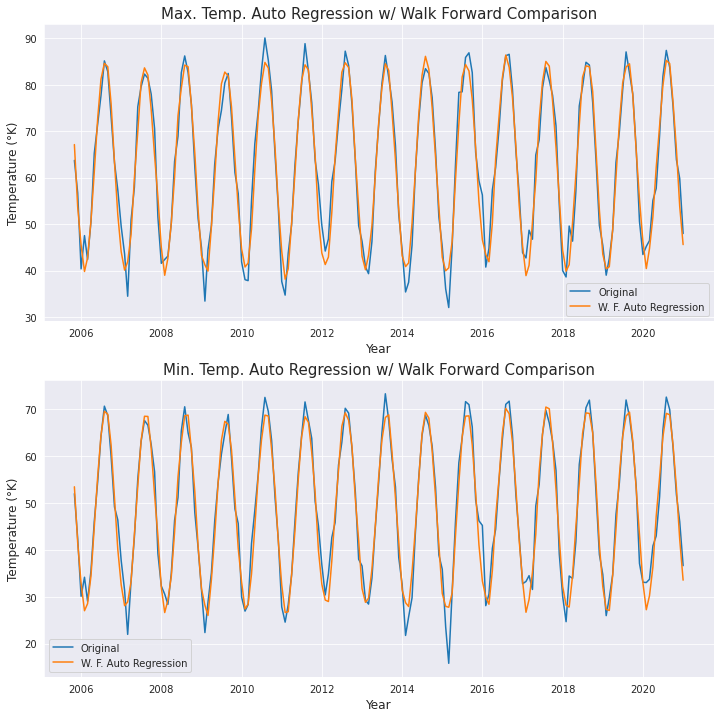

In [58]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 12))
sns.lineplot(x=y_test.index, y=y_test["TMAX"].values, label="Original", ax=axes[0])
sns.lineplot(x=y_test.index, y=tmax_predictions,
			 label="W. F. Auto Regression", ax=axes[0])
axes[0].set_title("Max. Temp. Auto Regression w/ Walk Forward Comparison", fontsize=15)
axes[0].set_ylabel("Temperature (°K)", fontsize=12)
axes[0].set_xlabel("Year", fontsize=12)
sns.lineplot(x=y_test.index, y=y_test["TMIN"].values, label="Original", ax=axes[1])
sns.lineplot(x=y_test.index, y=tmin_predictions,
			 label="W. F. Auto Regression", ax=axes[1])
axes[1].set_title("Min. Temp. Auto Regression w/ Walk Forward Comparison", fontsize=15)
axes[1].set_ylabel("Temperature (°K)", fontsize=12)
axes[1].set_xlabel("Year", fontsize=12)
plt.show()

### Moving Average Model

define the model

In [59]:
X_train, y_train = train[["tmax_diff1", "tmin_diff1"]], train[["TMAX", "TMIN"]]
X_test, y_test = test[["tmax_diff1", "tmin_diff1"]], test[["TMAX", "TMIN"]]

tmax_model = AutoReg(train["tmax_diff1"], lags=50)
tmin_model = AutoReg(train["tmin_diff1"], lags=50)
tmax_model_fit = tmax_model.fit()
tmin_model_fit = tmin_model.fit()

calculate the mean absolute error

In [60]:
tmax_resid = tmax_model_fit.predict(start=len(train), end=len(train) + len(test) - 1)
tmin_resid = tmin_model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

tmax_predictions = test["tmax_lag1"] + tmax_resid
tmin_predictions = test["tmin_lag1"] + tmin_resid
tmax_mae = mean_absolute_error(y_test["TMAX"], tmax_predictions)
tmin_mae = mean_absolute_error(y_test["TMIN"], tmin_predictions)
print(tmax_mae)
print(tmin_mae)

3.353801042003377
3.0551018345588745


plot the predictions

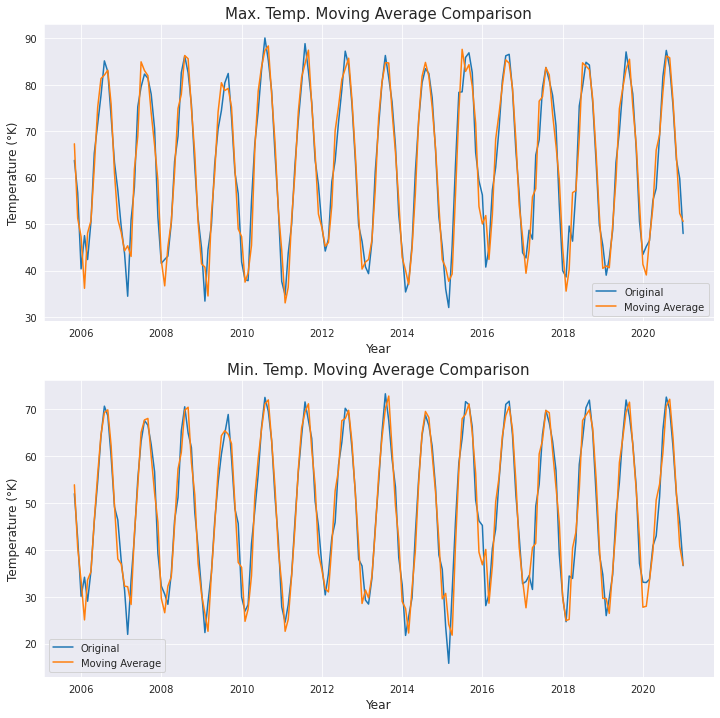

In [61]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 12))
sns.lineplot(x=y_test.index, y=y_test["TMAX"].values, label="Original", ax=axes[0])
sns.lineplot(x=y_test.index, y=tmax_predictions,
			 label="Moving Average", ax=axes[0])
axes[0].set_title("Max. Temp. Moving Average Comparison", fontsize=15)
axes[0].set_ylabel("Temperature (°K)", fontsize=12)
axes[0].set_xlabel("Year", fontsize=12)
sns.lineplot(x=y_test.index, y=y_test["TMIN"].values, label="Original", ax=axes[1])
sns.lineplot(x=y_test.index, y=tmin_predictions,
			 label="Moving Average", ax=axes[1])
axes[1].set_title("Min. Temp. Moving Average Comparison", fontsize=15)
axes[1].set_ylabel("Temperature (°K)", fontsize=12)
axes[1].set_xlabel("Year", fontsize=12)
plt.show()

### Moving Average with Walk Forward

define the model

In [66]:
data = train["tmax_diff1"].copy()
tmax_predictions = []
for i, t in enumerate(test["tmax_diff1"]):
	model = AutoReg(data, lags=50)
	model_fit = model.fit()
	pred_resid = model_fit.predict(start=len(data), end=len(train) + len(test) - 1)
	pred_resid = pd.Series(index=test.index[i:], data=pred_resid.values)
	y = test["tmax_lag1"][i:] + pred_resid
	tmax_predictions.append(y.values[0])
	data = np.append(data, t)
	data = pd.Series(data)

data = train["tmin_diff1"].copy()
tmin_predictions = []
for i, t in enumerate(test["tmin_diff1"]):
	model = AutoReg(data, lags=50)
	model_fit = model.fit()
	pred_resid = model_fit.predict(start=len(data), end=len(train) + len(test) - 1)
	pred_resid = pd.Series(index=test.index[i:], data=pred_resid.values)
	y = test["tmin_lag1"][i:] + pred_resid
	tmin_predictions.append(y.values[0])
	data = np.append(data, t)
	data = pd.Series(data)

calculate the mean absolute error

In [67]:
tmax_mae = mean_absolute_error(y_test["TMAX"], tmax_predictions)
tmin_mae = mean_absolute_error(y_test["TMIN"], tmin_predictions)
print(tmax_mae)
print(tmin_mae)

2.816613608185418
2.4584260515775664


plot the results

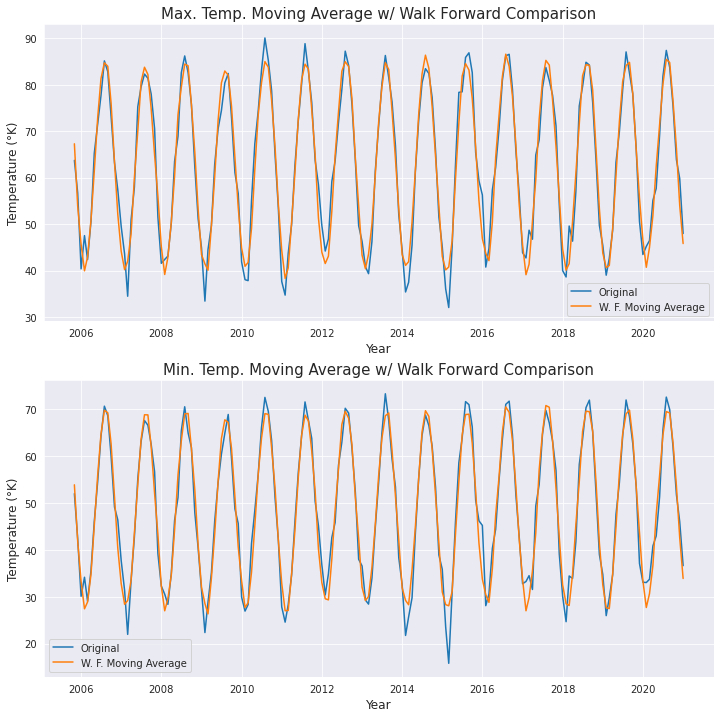

In [68]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 12))
sns.lineplot(x=y_test.index, y=y_test["TMAX"].values, label="Original", ax=axes[0])
sns.lineplot(x=y_test.index, y=tmax_predictions,
			 label="W. F. Moving Average", ax=axes[0])
axes[0].set_title("Max. Temp. Moving Average w/ Walk Forward Comparison", fontsize=15)
axes[0].set_ylabel("Temperature (°K)", fontsize=12)
axes[0].set_xlabel("Year", fontsize=12)
sns.lineplot(x=y_test.index, y=y_test["TMIN"].values, label="Original", ax=axes[1])
sns.lineplot(x=y_test.index, y=tmin_predictions,
			 label="W. F. Moving Average", ax=axes[1])
axes[1].set_title("Min. Temp. Moving Average w/ Walk Forward Comparison", fontsize=15)
axes[1].set_ylabel("Temperature (°K)", fontsize=12)
axes[1].set_xlabel("Year", fontsize=12)
plt.show()

### SARIMAX Model

In [70]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

tmax_model = SARIMAX(monthly_df["TMAX"], order=(1, 2, 10), seasonal_order=(1, 1, 1, 12))
tmin_model = SARIMAX(monthly_df["TMIN"], order=(1, 2, 10), seasonal_order=(1, 1, 1, 12))
tmax_model_fit = tmax_model.fit(maxiter=100, disp=0)
tmin_model_fit = tmin_model.fit(maxiter=100, disp=0)

/home/cris/miniconda3/envs/data/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


plot the residuals

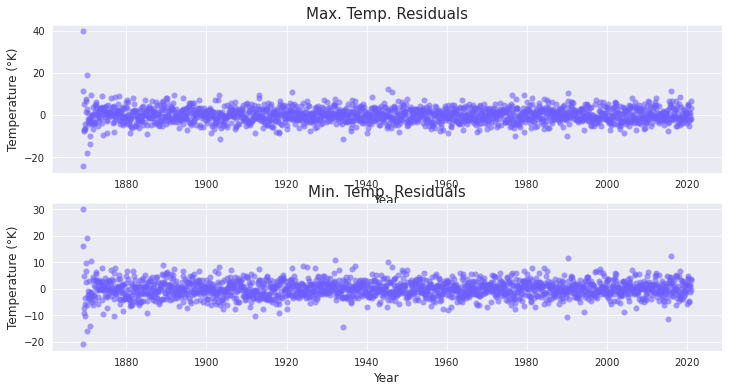

In [71]:
tmax_residuals = tmax_model_fit.resid
tmin_residuals = tmin_model_fit.resid

fig, axes = plt.subplots(nrows=2, figsize=(12, 6))
sns.scatterplot(x=tmax_residuals.index, y=tmax_residuals.values, linewidth=0, alpha=0.6,
                color="#6E5EFF", ax=axes[0])
axes[0].set_title("Max. Temp. Residuals", fontsize=15)
axes[0].set_ylabel("Temperature (°K)", fontsize=12)
axes[0].set_xlabel("Year", fontsize=12)
sns.scatterplot(x=tmin_residuals.index, y=tmin_residuals.values, linewidth=0, alpha=0.6,
				color="#6E5EFF", ax=axes[1])
axes[1].set_title("Min. Temp. Residuals", fontsize=15)
axes[1].set_ylabel("Temperature (°K)", fontsize=12)
axes[1].set_xlabel("Year", fontsize=12)
plt.show()

calculate the mean absolute error on the test set.

In [72]:
tmax_yhat = tmax_model_fit.predict()
tmin_yhat = tmin_model_fit.predict()
tmax_mae = mean_absolute_error(y_test["TMAX"], tmax_yhat[-len(y_test):])
tmin_mae = mean_absolute_error(y_test["TMIN"], tmin_yhat[-len(y_test):])
print(tmax_mae)
print(tmin_mae)

2.6585377956258873
2.3175923352252146


We see that the better score is achieved by the SARIMAX model.


we plot the sarimax temperature prediction to compare with the original

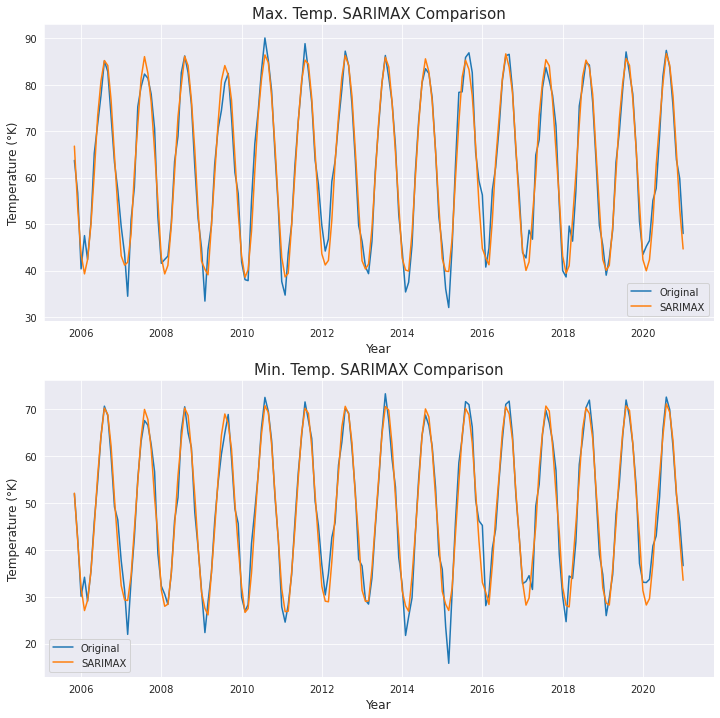

In [74]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 12))
sns.lineplot(x=y_test.index, y=y_test["TMAX"].values, label="Original", ax=axes[0])
sns.lineplot(x=y_test.index, y=tmax_yhat[-len(y_test):].values,
			 label="SARIMAX", ax=axes[0])
axes[0].set_title("Max. Temp. SARIMAX Comparison", fontsize=15)
axes[0].set_ylabel("Temperature (°K)", fontsize=12)
axes[0].set_xlabel("Year", fontsize=12)
sns.lineplot(x=y_test.index, y=y_test["TMIN"].values, label="Original", ax=axes[1])
sns.lineplot(x=y_test.index, y=tmin_yhat[-len(y_test):].values,
			 label="SARIMAX", ax=axes[1])
axes[1].set_title("Min. Temp. SARIMAX Comparison", fontsize=15)
axes[1].set_ylabel("Temperature (°K)", fontsize=12)
axes[1].set_xlabel("Year", fontsize=12)
plt.show()

## Yearly Analysis

In [75]:
tmax_yearly_pred = tmax_yhat.groupby(pd.Grouper(freq="Y")).mean()
tmin_yearly_pred = tmin_yhat.groupby(pd.Grouper(freq="Y")).mean()
tmax_yearly_mae = mean_absolute_error(yearly_df["TMAX"], tmax_yearly_pred)
tmin_yearly_mae = mean_absolute_error(yearly_df["TMIN"], tmin_yearly_pred)
print(tmax_yearly_mae)
print(tmin_yearly_mae)

0.742651705385053
0.6973092450919054


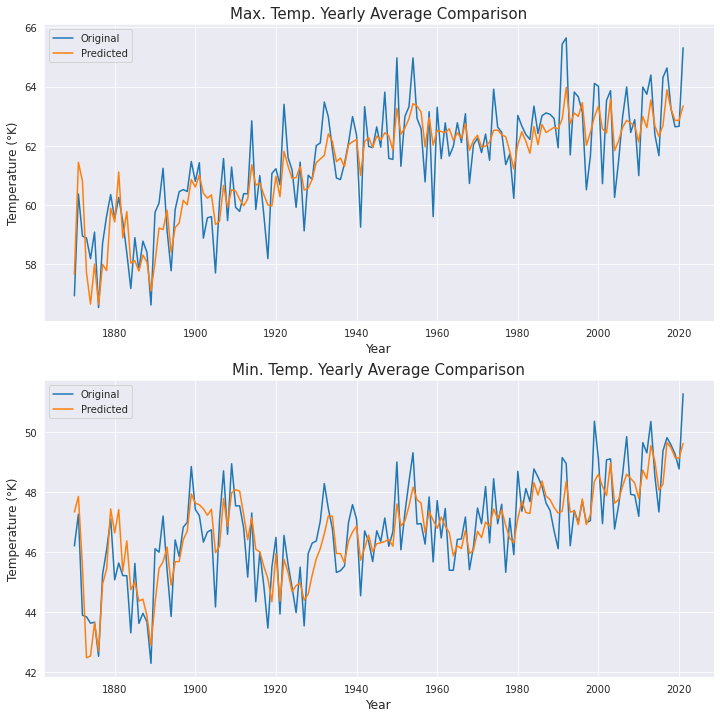

In [76]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 12))
sns.lineplot(x=yearly_df.index, y=yearly_df["TMAX"].values, label="Original", ax=axes[0])
sns.lineplot(x=tmax_yearly_pred.index, y=tmax_yearly_pred.values, label="Predicted", ax=axes[0])
axes[0].set_title("Max. Temp. Yearly Average Comparison", fontsize=15)
axes[0].set_ylabel("Temperature (°K)", fontsize=12)
axes[0].set_xlabel("Year", fontsize=12)
sns.lineplot(x=yearly_df.index, y=yearly_df["TMIN"].values, label="Original", ax=axes[1])
sns.lineplot(x=tmin_yearly_pred.index, y=tmin_yearly_pred.values, label="Predicted", ax=axes[1])
axes[1].set_title("Min. Temp. Yearly Average Comparison", fontsize=15)
axes[1].set_ylabel("Temperature (°K)", fontsize=12)
axes[1].set_xlabel("Year", fontsize=12)
plt.show()

### Predictions

make 100 years prediction

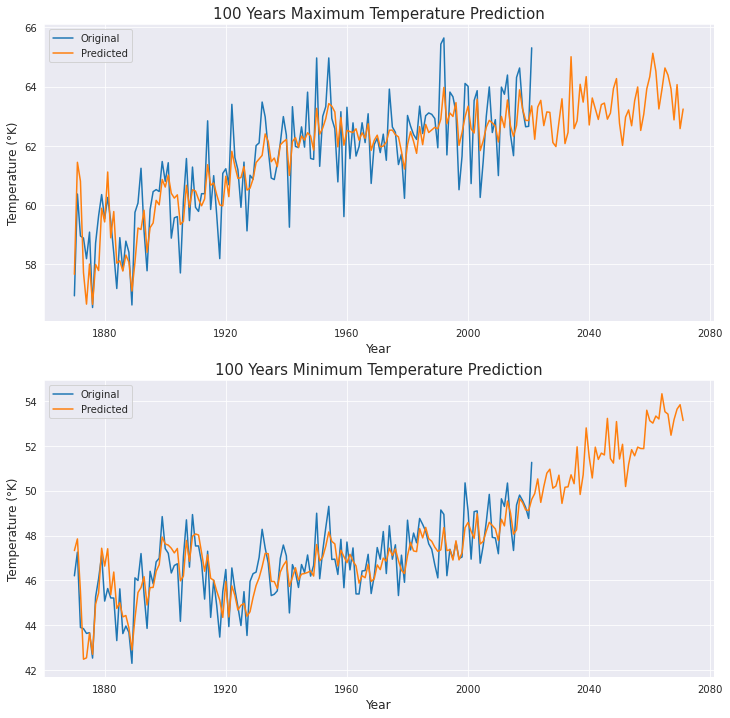

In [101]:
output = tmax_model_fit.forecast(600)
errors = pd.Series(index=output.index,
				   data=np.random.normal(loc=0, scale=tmax_mae, size=600))
output = output + errors
predictions = pd.concat([tmax_yhat, output], axis=0)
tmax_yearly_pred = predictions.groupby(pd.Grouper(freq="Y")).mean()

output = tmin_model_fit.forecast(600)
errors = pd.Series(index=output.index,
				   data=np.random.normal(loc=0, scale=tmin_mae, size=600))
output = output + errors
predictions = pd.concat([tmin_yhat, output], axis=0)
tmin_yearly_pred = predictions.groupby(pd.Grouper(freq="Y")).mean()

fig, axes = plt.subplots(nrows=2, figsize=(12, 12))
sns.lineplot(x=yearly_df.index, y=yearly_df["TMAX"].values, label="Original", ax=axes[0])
sns.lineplot(x=tmax_yearly_pred.index, y=tmax_yearly_pred.values, label="Predicted", ax=axes[0])
axes[0].set_title("100 Years Maximum Temperature Prediction", fontsize=15)
axes[0].set_ylabel("Temperature (°K)", fontsize=12)
axes[0].set_xlabel("Year", fontsize=12)
sns.lineplot(x=yearly_df.index, y=yearly_df["TMIN"].values, label="Original", ax=axes[1])
sns.lineplot(x=tmin_yearly_pred.index, y=tmin_yearly_pred.values, label="Predicted", ax=axes[1])
axes[1].set_title("100 Years Minimum Temperature Prediction", fontsize=15)
axes[1].set_ylabel("Temperature (°K)", fontsize=12)
axes[1].set_xlabel("Year", fontsize=12)
plt.show()

## Simulated Predictions

In [102]:
def simulated_predictions(model, pred_length, mae):
	output = model.forecast(pred_length)
	errors = pd.Series(index=output.index,
					   data=np.random.normal(loc=0, scale=mae, size=pred_length))
	output = output + errors
	yearly_predictions = output.groupby(pd.Grouper(freq="Y")).mean()
	return yearly_predictions

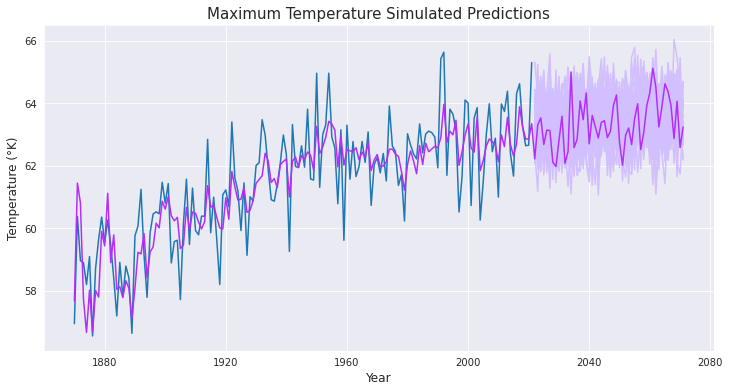

In [103]:
plt.figure(figsize=(12, 6))
plt.plot(yearly_df["TMAX"])

for i in range(40):
	yearly_predictions = simulated_predictions(tmax_model_fit, 600, tmax_mae)
	plt.plot(yearly_predictions, color="#D2BFFF")

plt.plot(tmax_yearly_pred, color="#B42DFA")
plt.title("Maximum Temperature Simulated Predictions", fontsize=15)
plt.ylabel("Temperature (°K)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.show()

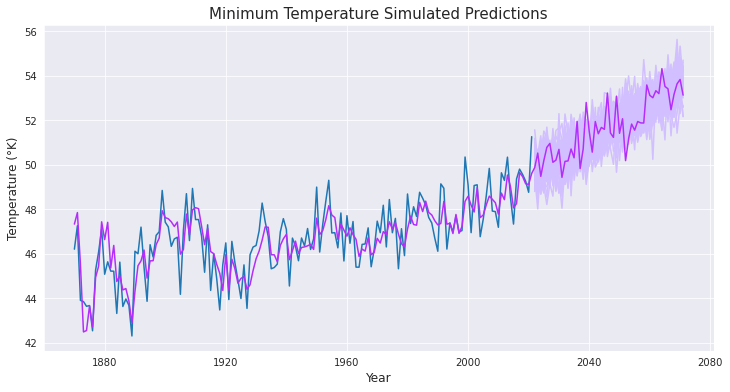

In [104]:
plt.figure(figsize=(12, 6))
plt.plot(yearly_df["TMIN"])

for i in range(40):
	yearly_predictions = simulated_predictions(tmin_model_fit, 600, tmin_mae)
	plt.plot(yearly_predictions, color="#D2BFFF")

plt.plot(tmin_yearly_pred, color="#B42DFA")
plt.title("Minimum Temperature Simulated Predictions", fontsize=15)
plt.ylabel("Temperature (°K)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.show()